In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/DATASET-balanced.csv
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/trump-to-Obama.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/margot-to-musk.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/linus-to-obama.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/taylor-to-trump.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/taylor-to-biden.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/ryan-to-trump.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/obama-to-musk.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/musk-to-trump.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/ryan-to-musk.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/trump-to-musk.wav
/kaggle/input/deep-voice-deepfake-

In [2]:
!pip install librosa
!pip install pydub

In [2]:
import os
import librosa
from pydub import AudioSegment
import random

dataset_path = "/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO"
augmented_dataset_path = "/kaggle/working/SPLITTED"

# bikin directory untuk data audio
os.makedirs(augmented_dataset_path, exist_ok=True)
os.makedirs(os.path.join(augmented_dataset_path, "FAKE"), exist_ok=True)
os.makedirs(os.path.join(augmented_dataset_path, "REAL"), exist_ok=True)

def split_audio_file(file_path, output_dir, segment_length=10):
    audio = AudioSegment.from_wav(file_path)
    duration = audio.duration_seconds
    segment_length_ms = segment_length * 1000  # dalam milliseconds

    segments = []
    for i in range(0, len(audio), segment_length_ms):
        segment = audio[i:i + segment_length_ms]
        segment_file_name = f"{os.path.splitext(os.path.basename(file_path))[0]}_part{i // segment_length_ms}.wav"
        segment_path = os.path.join(output_dir, segment_file_name)
        segment.export(segment_path, format="wav")
        segments.append(segment_path)
    return segments

# split audio menjadi sample" 10 detik agar data semakin banyak
real_samples_path = os.path.join(dataset_path, "REAL")
for file_name in os.listdir(real_samples_path):
    file_path = os.path.join(real_samples_path, file_name)
    output_dir = os.path.join(augmented_dataset_path, "REAL")
    split_audio_file(file_path, output_dir)

fake_samples_path = os.path.join(dataset_path, "FAKE")
fake_segments = []
for file_name in os.listdir(fake_samples_path):
    file_path = os.path.join(fake_samples_path, file_name)
    output_dir = os.path.join(augmented_dataset_path, "FAKE")
    fake_segments.extend(split_audio_file(file_path, output_dir))

# pilih data AI voice secara random sebanyak data real yang ada agar seimbang
selected_fake_segments = random.sample(fake_segments, len(os.listdir("/kaggle/working/SPLITTED/REAL")))

# bikin dan isi directory untuk data AI voice yang terpilih
selected_fake_path = os.path.join(augmented_dataset_path, "SELECTED_FAKE")
os.makedirs(selected_fake_path, exist_ok=True)

for segment in selected_fake_segments:
    segment_file_name = os.path.basename(segment)
    os.rename(segment, os.path.join(selected_fake_path, segment_file_name))

In [3]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# extract fitur MFCC
def extract_features(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs.T, axis=0)

fake_samples_path = "/kaggle/working/SPLITTED/SELECTED_FAKE"
real_samples_path = "/kaggle/working/SPLITTED/REAL"

features = []
labels = []

# ambil data AI voice
for file_name in os.listdir(fake_samples_path):
    file_path = os.path.join(fake_samples_path, file_name)
    if file_path.endswith('.wav'):
        features.append(extract_features(file_path))
        labels.append(0)  # Label 0 for fake
        
# ambil data real voice
for file_name in os.listdir(real_samples_path):
    file_path = os.path.join(real_samples_path, file_name)
    if file_path.endswith('.wav'):
        features.append(extract_features(file_path))
        labels.append(1)  # Label 1 for real

# split data menjadi training dan testing
X = np.array(features)
y = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=144
  warnings.warn(


In [4]:
from sklearn.neighbors import KNeighborsClassifier


In [5]:
knn = KNeighborsClassifier()

# training model KNN
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# evaluasi model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.9607843137254902
Precision: 0.9487179487179487
Recall: 0.9736842105263158
F1-score: 0.9610389610389611


In [7]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95        77
           1       0.96      0.95      0.95        76

    accuracy                           0.95       153
   macro avg       0.95      0.95      0.95       153
weighted avg       0.95      0.95      0.95       153



In [6]:
import joblib

# File path to save the model
model_path = 'knn_model.pkl'

# Save the model to disk
joblib.dump(knn, model_path)

['knn_model.pkl']

In [8]:
import sklearn
print(sklearn.__version__)

1.2.2


In [9]:
#using the model
def extract_features(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs.T, axis=0)
new_audio='/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/biden-to-linus.wav'
feature=extract_features(new_audio)
print(feature)

[-302.54306    127.27121    -14.28349      1.7166896  -11.172331
   -1.439992   -16.781767    -4.3160996   -4.7817674  -10.560547
   -3.4465292    1.9599619  -11.6650715]


In [10]:
model_path='/kaggle/working/knn_model.pkl'
load_model=joblib.load(model_path)
feature = np.array(feature).reshape(1, -1)

In [11]:
prediction=load_model.predict(feature)
print("Predicted value:",prediction[0])

Predicted value: 0


In [12]:
!pip install resampy


^C


In [25]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import IPython
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Reshape,MaxPooling2D, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
import os

paths = []
labels = []

# Define the root directory
root_dir = '/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO'

# Iterate through the subdirectories
for subdir in os.listdir(root_dir):
    subdir_path = os.path.join(root_dir, subdir)
    # Check if it's a directory
    if os.path.isdir(subdir_path):
        # Add all files in the subdirectory
        for filename in os.listdir(subdir_path):
            file_path = os.path.join(subdir_path, filename)
            paths.append(file_path)
            # Add label based on the subdirectory name
            labels.append(subdir)

print('Dataset is loaded')

Dataset is loaded


In [14]:
len(paths)


64

In [15]:
paths[:5]


['/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/trump-to-Obama.wav',
 '/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/margot-to-musk.wav',
 '/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/linus-to-obama.wav',
 '/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/taylor-to-trump.wav',
 '/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/taylor-to-biden.wav']

In [16]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels

In [17]:
df['label'].value_counts()


label
FAKE    56
REAL     8
Name: count, dtype: int64

In [18]:
audio_path = '/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO'
real_audio_path = 'REAL'
fake_audio_path = 'FAKE'

In [19]:
folders = os.listdir(audio_path)
print(folders)

['FAKE', 'REAL']


In [20]:
real_audio = '/kaggle/input/deep-voice-deepfake-voice-recognition/DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3'
fake_audio = '/kaggle/input/deep-voice-deepfake-voice-recognition/DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3'

In [22]:
import IPython
print('Real Audio:')
IPython.display.Audio(real_audio)

Real Audio:


In [23]:
print('Fake Audio:')
IPython.display.Audio(fake_audio)

Fake Audio:


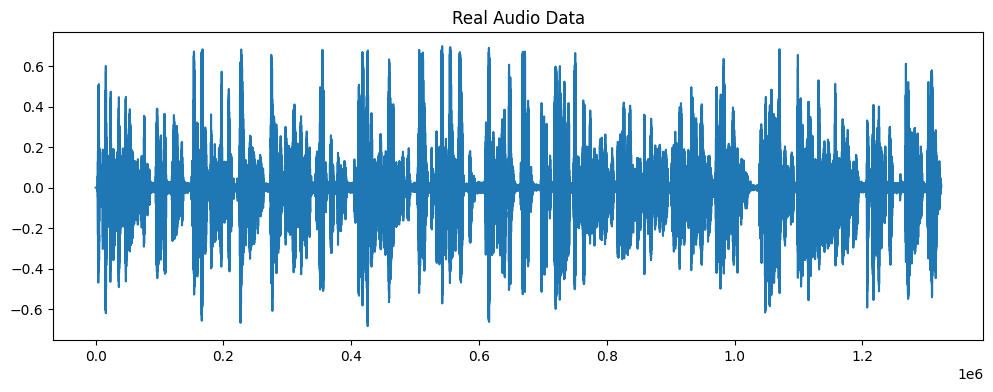

In [26]:
real_ad, real_sr = librosa.load(real_audio)
plt.figure(figsize= (12,4))
plt.plot(real_ad)
plt.title('Real Audio Data')
plt.show()

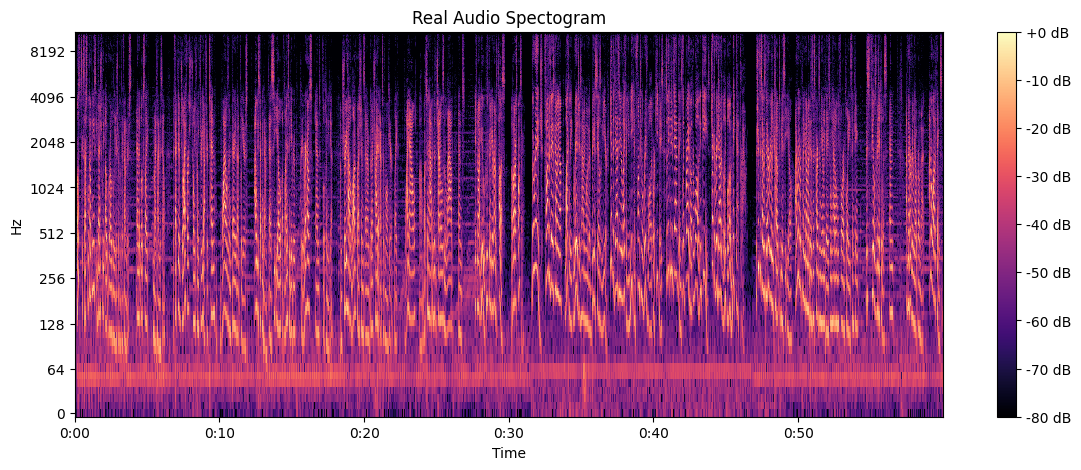

In [26]:
real_spec = np.abs(librosa.stft(real_ad))
real_spec = librosa.amplitude_to_db(real_spec, ref = np.max)
plt.figure(figsize=(14,5))
librosa.display.specshow(real_spec, sr = real_sr, x_axis = 'time', y_axis = 'log')
plt.colorbar(format = '%+2.0f dB')
plt.title("Real Audio Spectogram")
plt.show()

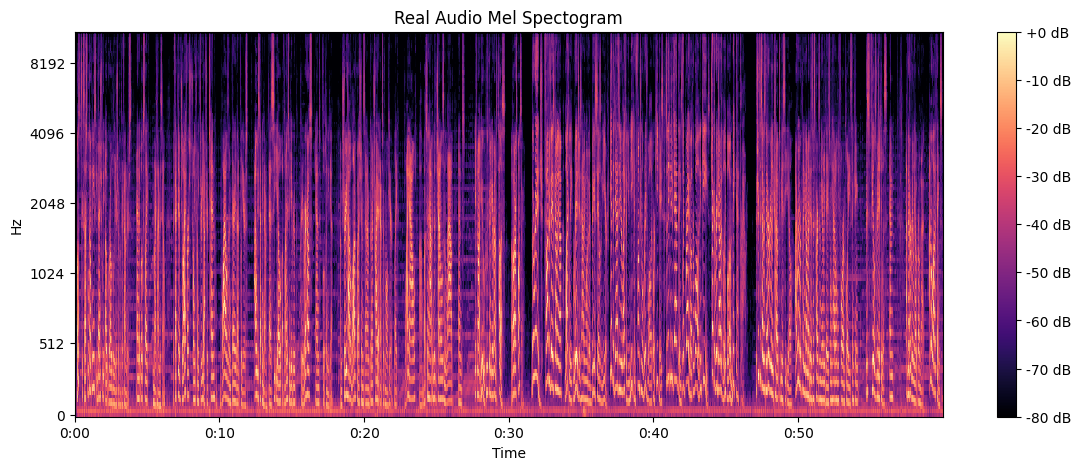

In [27]:
real_mel_spect = librosa.feature.melspectrogram(y = real_ad, sr = real_sr)
real_mel_spect = librosa.power_to_db(real_mel_spect, ref = np.max)
plt.figure(figsize = (14,5))
librosa.display.specshow(real_mel_spect, y_axis ='mel', x_axis = 'time')
plt.title('Real Audio Mel Spectogram')
plt.colorbar(format = '%+2.0f dB')
plt.show()

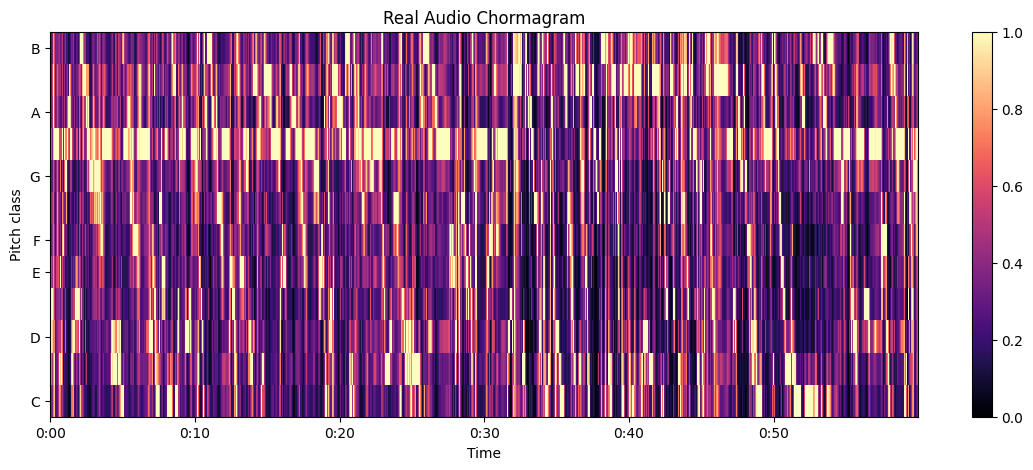

In [28]:
real_chroma = librosa.feature.chroma_cqt(y = real_ad, sr = real_sr, bins_per_octave=36)
plt.figure(figsize = (14, 5))
librosa.display.specshow(real_chroma, sr = real_sr, x_axis = 'time', y_axis = 'chroma', vmin = 0, vmax = 1)
plt.colorbar()
plt.title('Real Audio Chormagram')
plt.show()

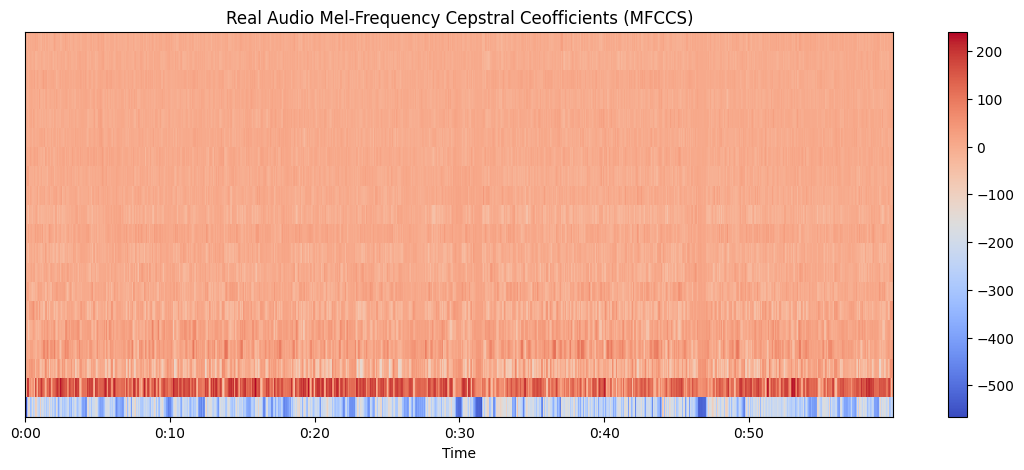

In [29]:
real_mfcc = librosa.feature.mfcc(y = real_ad, sr = real_sr)
plt.figure(figsize = (14,5))
librosa.display.specshow(real_mfcc, sr = real_sr, x_axis ='time')
plt.colorbar()
plt.title('Real Audio Mel-Frequency Cepstral Ceofficients (MFCCS)')
plt.show()

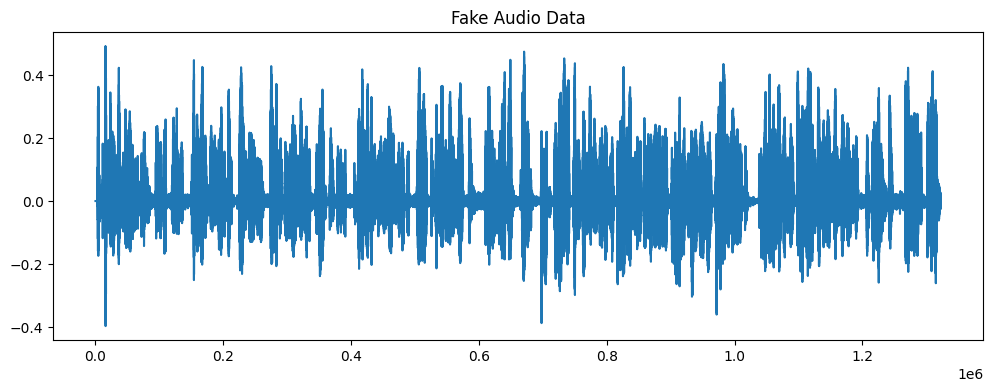

In [30]:
fake_ad, fake_sr = librosa.load(fake_audio)
plt.figure(figsize =(12,4))
plt.plot(fake_ad)
plt.title("Fake Audio Data")
plt.show()

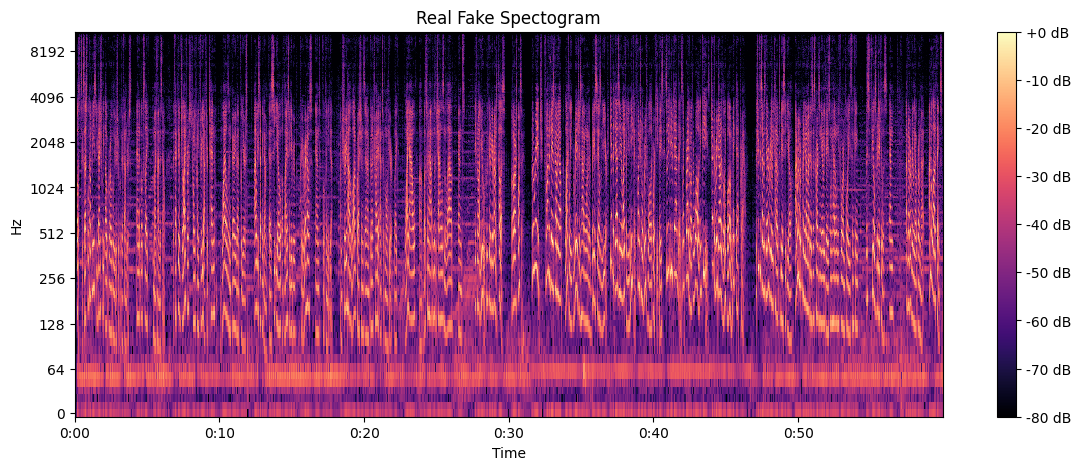

In [31]:
fake_spec = np.abs(librosa.stft(fake_ad))
fake_spec = librosa.amplitude_to_db(fake_spec, ref = np.max)
plt.figure(figsize=(14,5))
librosa.display.specshow(fake_spec, sr = fake_sr, x_axis = 'time', y_axis = 'log')
plt.colorbar(format = '%+2.0f dB')
plt.title("Real Fake Spectogram")
plt.show()

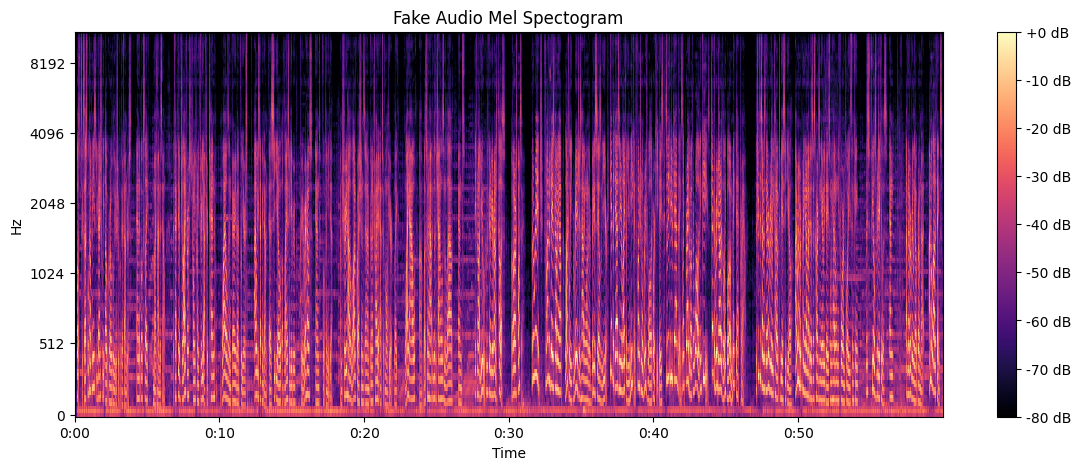

In [32]:
fake_mel_spect = librosa.feature.melspectrogram(y = fake_ad, sr = fake_sr)
fake_mel_spect = librosa.power_to_db(fake_mel_spect, ref = np.max)
plt.figure(figsize = (14,5))
librosa.display.specshow(fake_mel_spect, y_axis ='mel', x_axis = 'time')
plt.title('Fake Audio Mel Spectogram')
plt.colorbar(format = '%+2.0f dB')
plt.show()

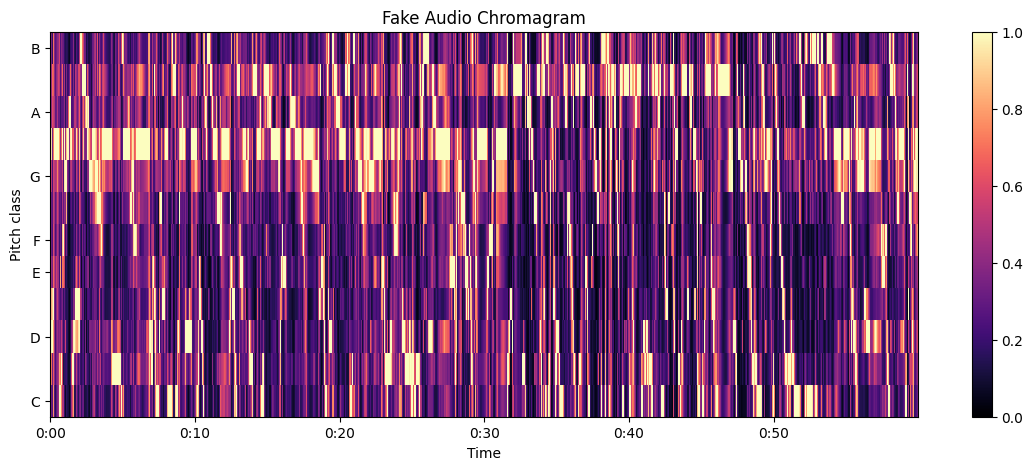

In [33]:
fake_chroma = librosa.feature.chroma_cqt(y = fake_ad, sr = fake_sr, bins_per_octave=36)
plt.figure(figsize=(14,5))
librosa.display.specshow(fake_chroma, sr = fake_sr, x_axis= 'time', y_axis = 'chroma', vmin = 0, vmax = 1)
plt.colorbar()
plt.title('Fake Audio Chromagram')
plt.show()

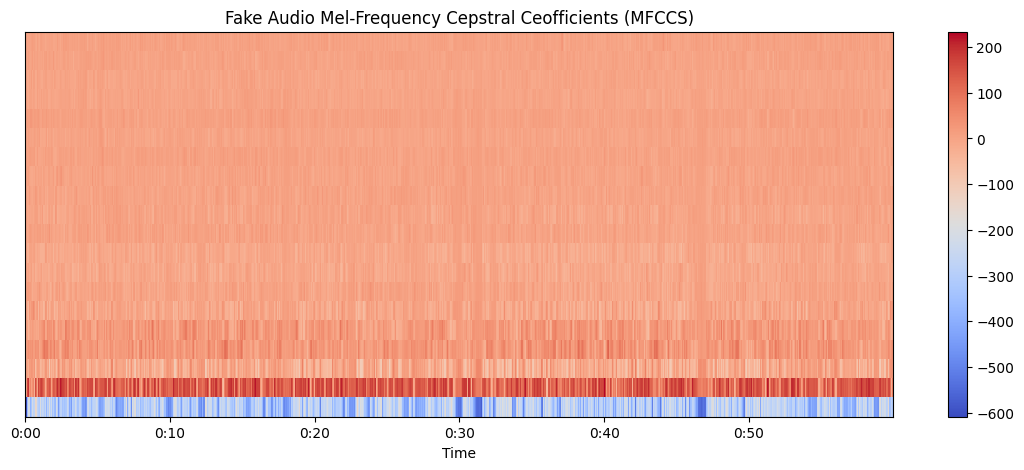

In [34]:
fake_mfcc = librosa.feature.mfcc(y = fake_ad, sr = fake_sr)
plt.figure(figsize = (14,5))
librosa.display.specshow(fake_mfcc, sr = fake_sr, x_axis ='time')
plt.colorbar()
plt.title('Fake Audio Mel-Frequency Cepstral Ceofficients (MFCCS)')
plt.show()

In [35]:
from tqdm import tqdm
import numpy as np
import os
import librosa

def extract_features(audio_path, max_length=500):
    features = []
    labels = []
    for folder in os.listdir(audio_path):
        folder_path = os.path.join(audio_path, folder)
        for file in tqdm(os.listdir(folder_path)):
            file_path = os.path.join(folder_path, file)
            try:
                # Load audio file
                audio, _ = librosa.load(file_path, sr=16000)
                # Extract features (example: using Mel-Frequency Cepstral Coefficients)
                mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=40)
                # Pad or trim the feature array to a fixed length
                if mfccs.shape[1] < max_length:
                    mfccs = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])), mode='constant')
                else:
                    mfccs = mfccs[:, :max_length]
                features.append(mfccs)
                # Assign label
                if folder == 'FAKE':
                    labels.append(1)  # 1 for fake
                else:
                    labels.append(0)  # 0 for real
            except Exception as e:
                print(f"Error encountered while parsing file: {file_path}")
                continue
    return np.array(features), np.array(labels)

# Example usage
audio_path = '/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO'
x, y = extract_features(audio_path)

print("Features shape:", x.shape)
print("Labels shape:", y.shape)

100%|██████████| 8/8 [00:10<00:00,  1.30s/it]

Features shape: (64, 40, 500)
Labels shape: (64,)


In [36]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = .1)


In [38]:
model = Sequential([
    Reshape((40, 500, 1), input_shape=xtrain.shape[1:]),  # Reshape input to add channel dimension
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [40]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics  = ['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)                  │ (None, 40, 500, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 38, 498, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 19, 249, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 17, 247, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 123, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 62976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       8,061,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,080,001 (30.82 MB)

 Trainable params: 8,080,001 (30.82 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model.fit(xtrain, ytrain, epochs = 100, batch_size = 32, validation_data = [xtest,ytest])


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.3783 - loss: 36.6165 - val_accuracy: 0.7143 - val_loss: 179.5515
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9090 - loss: 58.6768 - val_accuracy: 0.7143 - val_loss: 109.0926
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9090 - loss: 25.9670 - val_accuracy: 0.7143 - val_loss: 51.4277
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8777 - loss: 19.8095 - val_accuracy: 0.7143 - val_loss: 18.4492
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8986 - loss: 4.4972 - val_accuracy: 0.7143 - val_loss: 4.9658
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8101 - loss: 3.1361 - val_accuracy: 0.7143 - val_loss: 0.8153
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6932 - loss: 0.8284 - val_accuracy: 0.7143 - val_loss: 0.5457
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7100 - loss: 0.4778 - val_accuracy: 0.7143 - v

In [42]:
loss,accuracy = model.evaluate(xtest,ytest)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7143 - loss: 6.3198


In [43]:
model.save("resnet50.h5")

In [51]:
from sklearn.metrics import classification_report

In [ ]:

y_pred = model.predict(xtest)
y_pred_classes = (y_pred > 0.5).astype(int) 

# Bước 3: Đánh giá hiệu suất mô hình
report = classification_report(ytest, y_pred_classes)
print(report)


In [46]:
import numpy as np
import librosa
from tensorflow.keras.models import load_model

def extract_features_from_file(file_path, max_length=500):
    audio, _ = librosa.load(file_path, sr=16000)
    mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=40)
    if mfccs.shape[1] < max_length:
        mfccs = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])), mode='constant')
    else:
        mfccs = mfccs[:, :max_length]
    return mfccs

audio_file_path = '/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/Obama-to-Trump.wav'

features = extract_features_from_file(audio_file_path)

features = np.expand_dims(features, axis=-1)
features = np.expand_dims(features, axis=0)  # Thêm chiều batch

model = load_model('/kaggle/working/resnet50.h5')

prediction = model.predict(features)
predicted_class = (prediction > 0.5).astype(int)

print(f"Predicted class: {predicted_class[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
Predicted class: 1
